In [32]:
import numpy as np
from matplotlib import pyplot as plt

In [176]:
PERIOD = 2

def flat_potential(x):
    return np.zeros_like(x)
    
def ratchet_potential(x, slope1=1., slope2=-0.1, period=PERIOD):
    intersection = - slope2 * period / (slope1 - slope2)
    x_reduced = x % period
    return np.where(x_reduced < intersection, slope1, slope2) * x_reduced + np.where(x_reduced < intersection, 0, (slope1 - slope2) * intersection)

In [177]:
xs = np.arange(0, PERIOD * 3, PERIOD * 1E-3)

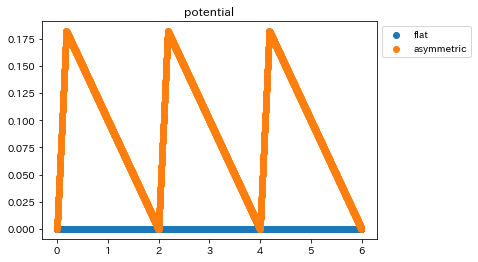

In [178]:
plt.scatter(xs, flat_potential(xs), label="flat")
plt.scatter(xs, ratchet_potential(xs), label="asymmetric")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title("potential")
plt.show()

In [179]:
def differential(f, dx=1E-5):
    return lambda x: (f(x + dx) - f(x - dx)) / (2 * dx)

In [180]:
derivative_flat_potential = differential(flat_potential, dx=PERIOD * 1E-3)
derivative_ratchet_potential = differential(ratchet_potential, dx=PERIOD * 1E-3)

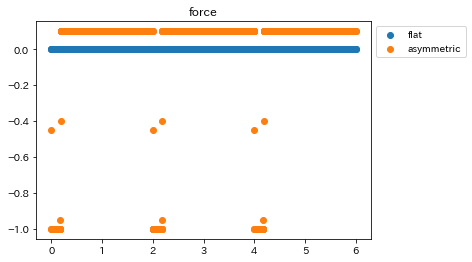

In [187]:
plt.scatter(xs, - derivative_flat_potential(xs), label="flat")
plt.scatter(xs, - derivative_ratchet_potential(xs), label="asymmetric")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title("force")
plt.show()

In [199]:
TEMPARATURE = 1E-1  # 温度
VISCOSITY_COEFFICIENT = 1.  # 粘性係数
DELTA_T = 1  # 1 stepのシミュレーションで進む時間

NUM_ITERATION = 100000  # 何ステップシミュレーションするか
NUM_ITERATION_FLAT = 10000  # 何ステップ間フラットなポテンシャルにするか
NUM_ITERATION_RATCHET = 10000  # 何ステップ間ラチェットポテンシャルにするか

np.random.seed(39)

In [200]:
def simulate_brownian_ratchet(temparature, 
                    viscosity_coefficient, 
                    delta_t,
                    num_iteration,
                    num_iteration_flat,
                    num_iteration_ratchet,
                    boltzmann_constant=1):
    x_trajectory = [0]
    for i in range(num_iteration):
        if i % (num_iteration_flat + num_iteration_ratchet) < num_iteration_flat:
            derivative = derivative_flat_potential
        else:
            derivative = derivative_ratchet_potential

        x_next = (x_trajectory[i] 
                    + np.sqrt(2 * boltzmann_constant * temparature / viscosity_coefficient * delta_t) * np.random.randn()
                    - derivative(x_trajectory[i]) / viscosity_coefficient * delta_t)
        x_trajectory.append(x_next)
    return x_trajectory

In [201]:
x_trajectory_brownian_ratchet = simulate_brownian_ratchet(TEMPARATURE,
                                                        VISCOSITY_COEFFICIENT,
                                                        DELTA_T,
                                                        NUM_ITERATION,
                                                        NUM_ITERATION_FLAT,
                                                        NUM_ITERATION_RATCHET,
                                                        )

x_trajectory_brownian = simulate_brownian_ratchet(TEMPARATURE,
                                                        VISCOSITY_COEFFICIENT,
                                                        DELTA_T,
                                                        NUM_ITERATION,
                                                        NUM_ITERATION_FLAT,
                                                        0,
                                                        )

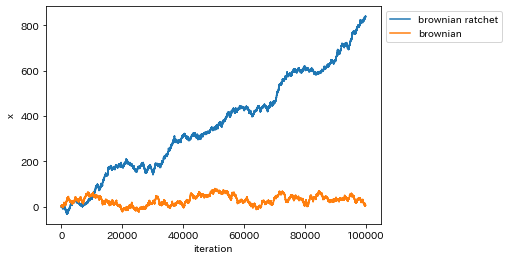

In [202]:
plt.plot(x_trajectory_brownian_ratchet, label="brownian ratchet")
plt.plot(x_trajectory_brownian, label="brownian")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel("iteration")
plt.ylabel("x")
plt.show()

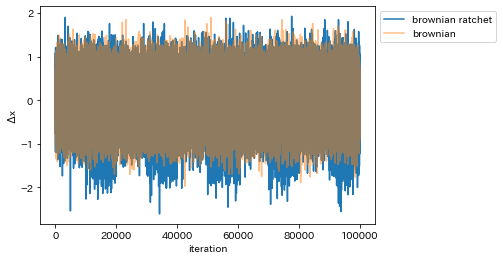

average of Δx
brownian ratchet : 0.008395162632983764
brownian : 7.452360118340567e-05


In [203]:
plt.plot(np.diff(x_trajectory_brownian_ratchet, 1), label="brownian ratchet")
plt.plot(np.diff(x_trajectory_brownian, 1), alpha=0.5, label="brownian")
plt.xlabel("iteration")
plt.ylabel("Δx")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()
plt.show()
print(f"average of Δx")
print(f"brownian ratchet : {np.average(np.diff(x_trajectory_brownian_ratchet, 1))}")
print(f"brownian : {np.average(np.diff(x_trajectory_brownian, 1))}")